## Kode til FN's verdensmål


# Load packages

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tools import *
import seaborn as sns
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

### Link to data on goals: https://dashboards.sdgindex.org/downloads/
### Link to data on population: https://data.worldbank.org/indicator/SP.POP.TOTL?end=2024&name_desc=false&start=2000&utm_source=chatgpt.com

In [36]:
# --- Load SDG Index data ---
data_path = r"../data/full_data_set.xlsx"
df = pd.read_excel(data_path, sheet_name="Backdated SDG Index")

# Remove aggregates (ids starting with "_")
df = df[~df["id"].astype(str).str.startswith("_")].copy()

# --- Clean numeric columns (sdgi_s + goals) ---
goal_cols = [c for c in df.columns if c.startswith("goal")]
all_cols = ["sdgi_s"] + goal_cols
for col in all_cols:
    df[col] = df[col].astype(str).str.replace(",", ".").astype(float)

# --- Load population data ---
population_path = r"../data/population_data.xlsx"
df_pop = pd.read_excel(population_path, sheet_name="DATA")

# Reshape into long format
df_pop_long = df_pop.melt(
    id_vars=["Country Name", "Country Code"],
    var_name="year",
    value_name="population"
)
df_pop_long["year"] = pd.to_numeric(df_pop_long["year"], errors="coerce")

start_year, end_year = 2000, 2024

# Extract 2024 only
pop_2024 = df_pop_long[df_pop_long["year"] == end_year][["Country Code", "population"]]

# Split into start and end year
df_start = df[df["year"] == start_year].set_index("id")[all_cols+ ["indexreg_"]]
df_end   = df[df["year"] == end_year].set_index("id")[all_cols]

# --- Build structured DataFrame ---
summary = pd.DataFrame(index=df_start.index)

for col in all_cols:
    summary[f"{col}_start"] = df_start[col]
    summary[f"{col}_rel_change"] = (
        (df_end[col] - df_start[col])
    )
    
summary["region"] = df_start["indexreg_"]

# Add population
summary = summary.reset_index().merge(
    pop_2024, left_on="id", right_on="Country Code", how="left"
).drop(columns=["Country Code"])

# Force population to float immediately
summary["population"] = pd.to_numeric(summary["population"], errors="coerce").astype(float)

summary = summary.set_index("id")

# Build stable region → code mapping from the full dataset
region_categories = pd.Categorical(summary["region"].dropna()).categories
region_to_code = {region: i for i, region in enumerate(region_categories)}

# Compute and plot convergence parameter for a given goal

- **<span style="color:blue; font-size:18px">color_by_region = True</span>** → color dots by region  
- **<span style="color:blue; font-size:18px">scale_by_population = True</span>** → set marker sizes according to nation population  
- **<span style="color:blue; font-size:18px">show_weighted = True</span>** → add the weighted OLS estimate  


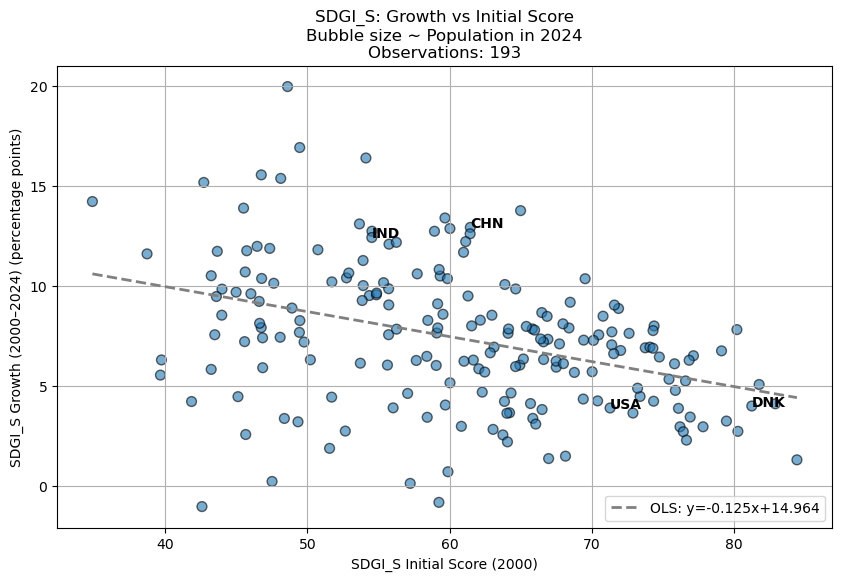

In [83]:
# Get all region categories from your summary
region_categories = pd.Categorical(summary["region"].dropna()).categories

# Assign consistent pastel colors
pastel_palette = sns.color_palette("pastel", len(region_categories))
region_to_color = dict(zip(region_categories, pastel_palette))

plot_growth_vs_initial(summary, goal="sdgi_s",
                       highlight_ids=["CHN","IND","USA","DNK"],
                       region_to_code=region_to_code,
                       region_categories=region_categories,
                       region_to_color=region_to_color,
                       color_by_region=False,
                       scale_by_population=False,
                       show_weighted=False)



# Computes and plots convergence parameter for each goal

### Set plot_all = True if you want to execute

In [82]:
plot_all = False
if plot_all:
    # --- Define which goals to loop over ---
    goals = ["sdgi_s"] + [f"goal{i}" for i in range(1, 18)]

    # Example: highlight some countries
    highlight_ids = ["CHN", "IND", "USA","DNK"]

    # Loop over all goals and plot
    for g in goals:
        plot_growth_vs_initial(summary,
                            goal=g,
                            highlight_ids=highlight_ids,
                            color_by_region=False,
                            region_to_code=region_to_code,
                            region_categories=region_categories,
                            region_to_color=region_to_color,
                            scale_by_population=False,
                            show_weighted=False)


# Compute development in convergence

## Choose periods and compute convergence parameter for each period and compare. The purpose is to see if the speed of convergence has increased/decreased over time.

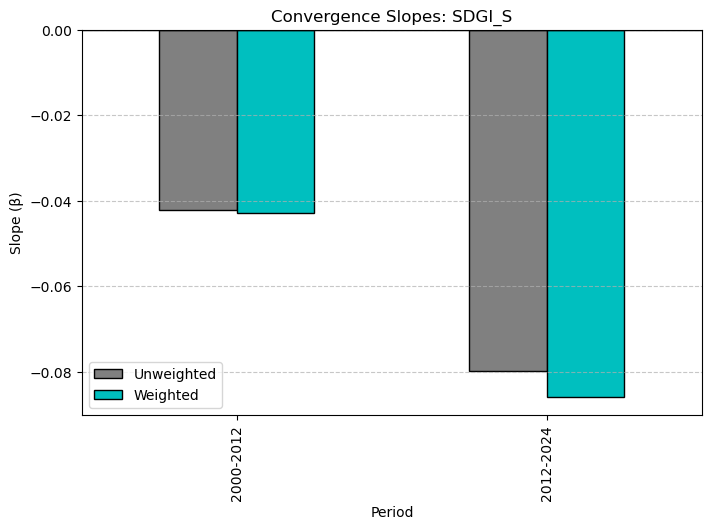

In [64]:
periods = [(2000,2012),(2012,2024)]

summaries = build_summaries(df, df_pop, periods)
results = compare_periods(summaries, goal="sdgi_s")
plot_beta_comparison(results, goal="sdgi_s")



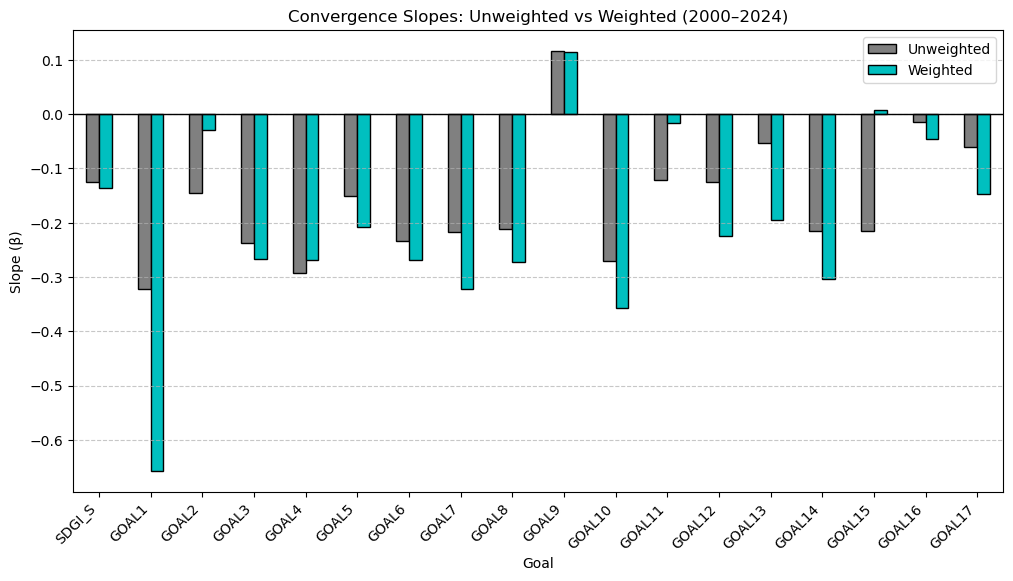

In [65]:
# --- Compute slopes for all goals ---
goal_cols = ["sdgi_s"] + [c for c in summary.columns if c.startswith("goal") and c.endswith("_start")]

results = []
for col in goal_cols:
    goal = col.replace("_start", "")
    m_unw, m_w = compute_fit(summary, goal=goal)
    results.append({"Goal": goal.upper(), "Unweighted": m_unw, "Weighted": m_w})

df_results = pd.DataFrame(results).set_index("Goal")

# --- Plot comparison ---
ax = df_results.plot(
    kind="bar",
    figsize=(12,6),
    color=["grey", "c"],      # unweighted = black, weighted = cyan
    edgecolor="black"
)
ax.axhline(0, color="black", linewidth=1)

plt.ylabel("Slope (β)")
plt.title("Convergence Slopes: Unweighted vs Weighted (2000–2024)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


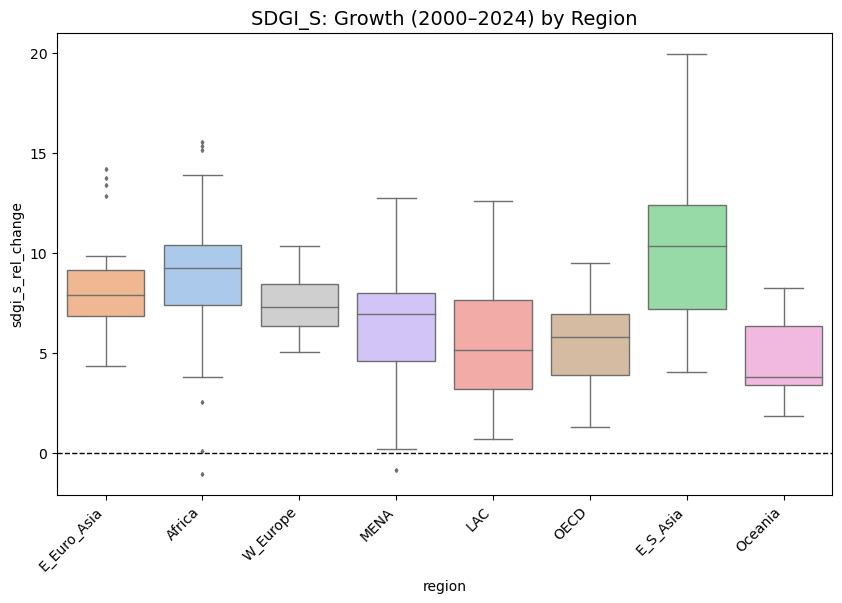

In [66]:
goal = "sdgi_s"
plt.figure(figsize=(10,6))
sns.boxplot(
    data=summary,
    x="region",
    y=f"{goal}_rel_change",
    palette=region_to_color,  # <---- SAME mapping
    linewidth=1,
    fliersize=2
)
plt.axhline(0, color="k", linestyle="--", linewidth=1)
plt.title(f"{goal.upper()}: Growth (2000–2024) by Region", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.show()


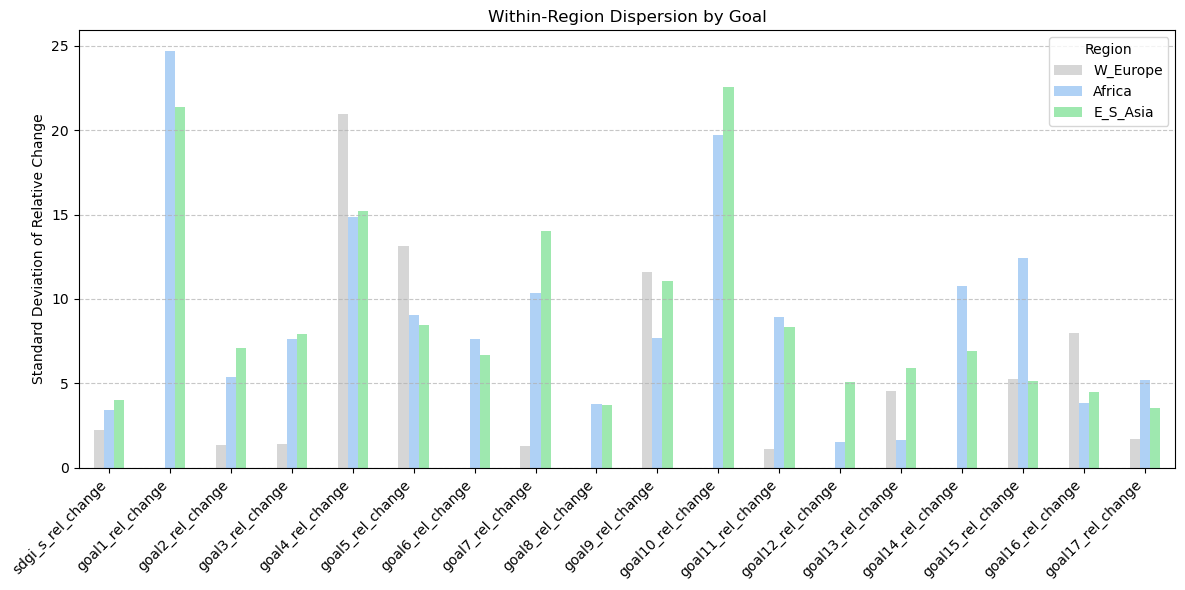

In [79]:
# --- Choose regions of interest ---
chosen_regions = ["W_Europe", "Africa", "E_S_Asia"]

# Select only *_rel_change columns
rel_change_cols = [c for c in summary.columns if c.endswith("_rel_change")]

# Compute std dev by region for each goal
region_std = (
    summary.groupby("region")[rel_change_cols]
           .std()
           .T   # transpose so goals are x-axis
)

# Keep only chosen regions
region_std = region_std[chosen_regions]

# --- Colors for chosen regions from your pastel mapping ---
colors = [region_to_color[r] for r in chosen_regions]

# --- Plot ---
ax = region_std.plot(kind="bar", figsize=(12,6), alpha=0.85, color=colors)

plt.ylabel("Standard Deviation of Relative Change")
plt.title("Within-Region Dispersion by Goal")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Region")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


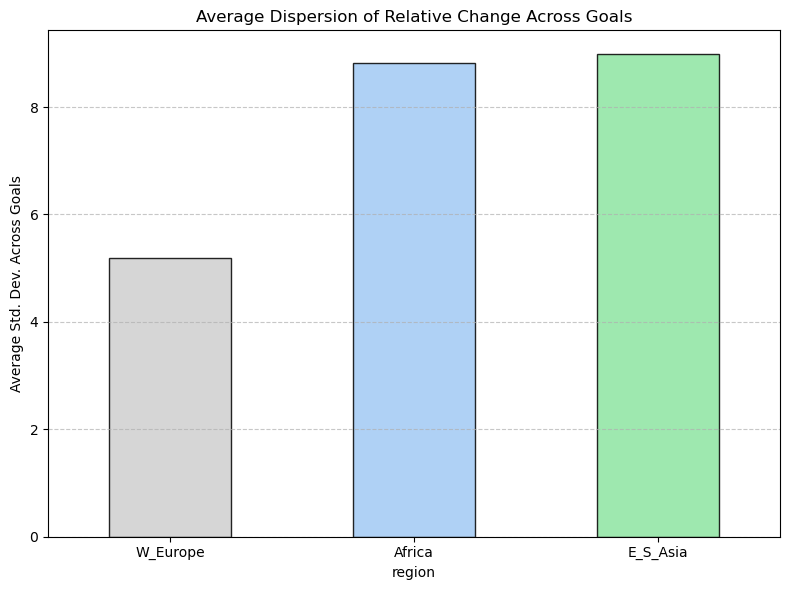

In [81]:
rel_change_cols = [c for c in summary.columns if c.endswith("_rel_change")]

# Compute std dev by region for each goal
region_std = (
    summary.groupby("region")[rel_change_cols]
           .std()
)

# Compute average std across all goals (per region)
region_avg_std = region_std.mean(axis=1)

# Keep only chosen regions
region_avg_std = region_avg_std[chosen_regions]

# --- Plot ---
colors = [region_to_color[r] for r in chosen_regions]
region_avg_std.plot(kind="bar", color=colors, edgecolor="black", alpha=0.85, figsize=(8,6))

plt.ylabel("Average Std. Dev. Across Goals")
plt.title("Average Dispersion of Relative Change Across Goals")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
